# Установка необходимых модулей

In [5]:
!pip install -U torch torchvision torchaudio numpy matplotlib ipywidgets tqdm

# Импортируем библиотеки

In [6]:
from pathlib import Path
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Настройки

In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Тип устройства, если есть GPU то пытаемся работать на нем
DATA_DIR = Path('data')  # Путь к датасету (папки классов внутри)
assert DATA_DIR.exists(), f'Папка DATA_DIR не найдена: {DATA_DIR}'

print('image source:', DATA_DIR)
print('device:', DEVICE)

image source: data
device: cuda


# Работа с данными

## 1. Загрузка данных и первичная проверка

Данные лежат в формате `ImageFolder`:
- каждая подпапка — это отдельный класс,
- все файлы внутри подпапки относятся к этому классу.

Сначала загрузим датасет и выведем список классов и общее количество изображений.

In [12]:
IMG_SIZE = 128  # размер изображений 128 × 128 пикселей

# Нормализация (ImageNet) — стандартный базовый вариант
IMAGENET_MEAN = (0.485, 0.456, 0.406) # Среднее значение каждого канала (R, G, B)
IMAGENET_STD = (0.229, 0.224, 0.225) # Стандартное отклонение каждого канала

# Для первичного анализа используем простой transform (без аугментаций)
base_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

base_ds = ImageFolder(root=DATA_DIR, transform=base_transform)

print('Всего изображений:', len(base_ds))
print('Количество классов:', len(base_ds.classes))
print('Классы:', base_ds.classes)
print('Сопоставление class_to_idx:', base_ds.class_to_idx)

x0, y0 = base_ds[0]
print('Пример одного элемента:')
print('  image tensor shape:', tuple(x0.shape))
print('  label:', y0, '(', base_ds.classes[y0], ')')

Всего изображений: 4317
Количество классов: 5
Классы: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Сопоставление class_to_idx: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Пример одного элемента:
  image tensor shape: (3, 128, 128)
  label: 0 ( daisy )


# 2 Статистика по файлам (сколько изображений каждого класса)

Суммарно изображений: 4317
Количество классов: 5
Картинок по классам:
            daisy: 764
        dandelion: 1052
             rose: 784
        sunflower: 733
            tulip: 984


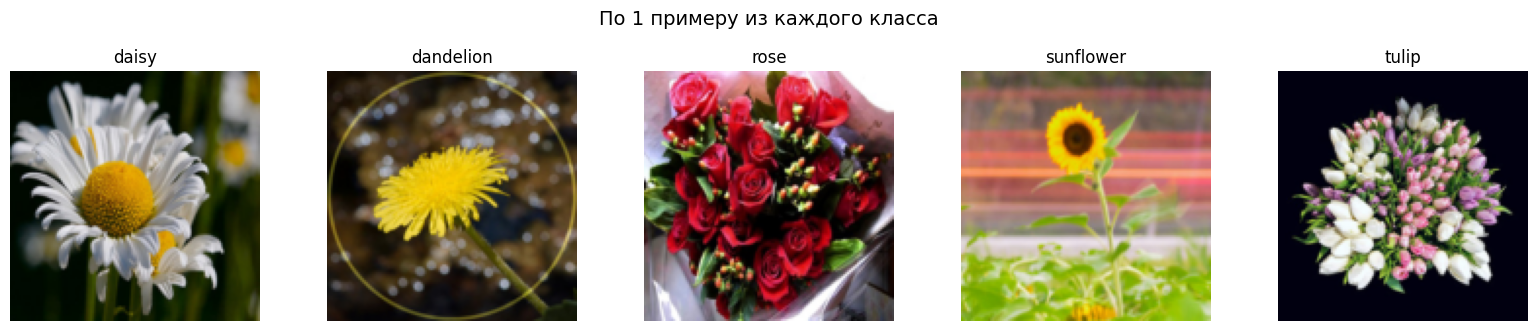

In [15]:
counts = {cls: 0 for cls in base_ds.classes}
for p, cls_idx in base_ds.samples:
    counts[base_ds.classes[cls_idx]] += 1

total = sum(counts.values())
print('Суммарно изображений:', total)
print('Количество классов:', len(counts))
print('Картинок по классам:')
for cls in sorted(counts.keys()):
    print(f'  {cls:>15s}: {counts[cls]}')

# Показать по одной случайной картинке на класс
# Соберём индексы для каждого класса
targets = np.array([y for _, y in base_ds.samples], dtype=np.int64)
indices_by_class = {i: np.where(targets == i)[0] for i in range(len(base_ds.classes))}

# Выберем по одному случайному индексу
example_indices = []

for i in range(len(base_ds.classes)):
    if len(indices_by_class[i]) == 0:
        continue
    example_indices.append(int(np.random.choice(indices_by_class[i])))

# Визуализация сеткой
n = len(example_indices)
cols = 5
rows = int(np.ceil(n / cols))

plt.figure(figsize=(3.2 * cols, 3.2 * rows))
for k, idx in enumerate(example_indices, start=1):
    img_t, y = base_ds[idx]
    img = img_t.permute(1, 2, 0).numpy()  # CHW -> HWC

    ax = plt.subplot(rows, cols, k)
    ax.imshow(img)
    ax.set_title(base_ds.classes[y])
    ax.axis('off')

plt.suptitle('По 1 примеру из каждого класса', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()